In this project, we will use CNN to train and test a traffic sign classification model.

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"duypha","key":"2ebd3f47911fd8a15f32aa4c3ac7048c"}'}

Connecting to Kaggle using Kaggle API.

In [ ]:
#install the Kaggle API client.
!pip install -q kaggle

In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle, so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Creating directory and changing the current working directory
!mkdir traffic_sign_dataset
%cd traffic_sign_dataset

/content/traffic_sign_dataset


In [ ]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

 99% 606M/612M [00:06<00:00, 111MB/s] 
100% 612M/612M [00:06<00:00, 99.7MB/s]


In [ ]:
# Unzipping file
!unzip gtsrb-german-traffic-sign.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/5/00005_00053_00010.png  
  inflating: train/5/00005_00053_00011.png  
  inflating: train/5/00005_00053_00012.png  
  inflating: train/5/00005_00053_00013.png  
  inflating: train/5/00005_00053_00014.png  
  inflating: train/5/00005_00053_00015.png  
  inflating: train/5/00005_00053_00016.png  
  inflating: train/5/00005_00053_00017.png  
  inflating: train/5/00005_00053_00018.png  
  inflating: train/5/00005_00053_00019.png  
  inflating: train/5/00005_00053_00020.png  
  inflating: train/5/00005_00053_00021.png  
  inflating: train/5/00005_00053_00022.png  
  inflating: train/5/00005_00053_00023.png  
  inflating: train/5/00005_00053_00024.png  
  inflating: train/5/00005_00053_00025.png  
  inflating: train/5/00005_00053_00026.png  
  inflating: train/5/00005_00053_00027.png  
  inflating: train/5/00005_00053_00028.png  
  inflating: train/5/00005_00053_00029.png  
  inflating: train/5/00005_00054_00000.png  
  in

In [ ]:
#Removing unusable file
!rm gtsrb-german-traffic-sign.zip
!rm -rf Meta
!rm -rf meta
!rm -rf test
!rm -rf train
!rm Meta.csv

In [ ]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

In [ ]:
# list paths
TRAFFICSIGN_DATA_PATH = 'Train'
path_imgs = list(glob.glob(TRAFFICSIGN_DATA_PATH+'/**/*.png'))


In [ ]:
labels = list(map(lambda x: os.path.split((os.path.split(x)[0]))[-1], path_imgs))

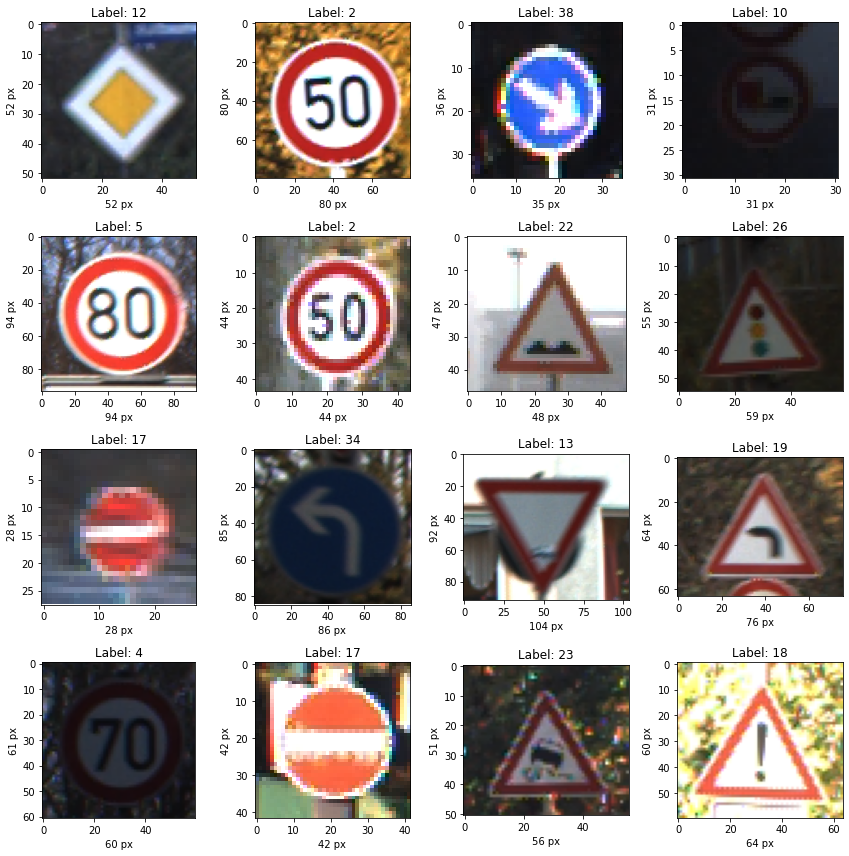

In [ ]:
# Plotting 12 images to check dataset
plt.figure(figsize=(12,12))
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    r = random.randint(0, len(labels) - 1)
    rand_img = imread(path_imgs[r])
    plt.imshow(rand_img)
    plt.title(f'Label: {labels[r]}')
    plt.xlabel(f'{rand_img.shape[1]} px', fontsize = 10)#width of image
    plt.ylabel(f'{rand_img.shape[0]} px', fontsize = 10)#height of image

In [ ]:
paths_pd = pd.Series(path_imgs).astype(str)
labels_pd = pd.Series(labels)
data = pd.concat([paths_pd, labels_pd], axis = 1)
data = data.sample(frac = 1)

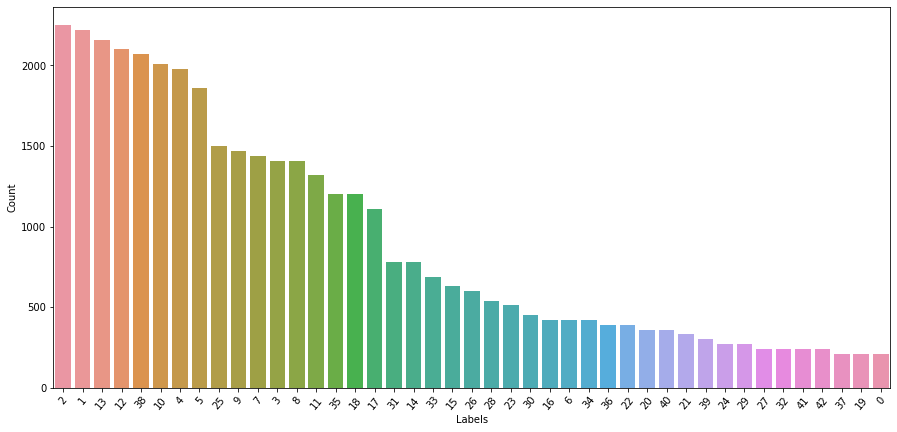

In [ ]:
# List number of images with each label 
plt.figure(figsize=(15,7))
counts = data[1].value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);

In [ ]:
data['img_height'] = data.apply(lambda x: imread(x[0]).shape[0], axis = 1)
data['img_width'] = data.apply(lambda x: imread(x[0]).shape[1], axis = 1)

In [ ]:
data

,0,1,img_height,img_width
24420,Train/13/00013_00010_00001.png,13,32,30
425,Train/24/00024_00002_00011.png,24,57,59
20911,Train/17/00017_00004_00020.png,17,28,28
5308,Train/2/00002_00050_00026.png,2,51,52
30883,Train/10/00010_00026_00022.png,10,42,42
...,...,...,...,...
29623,Train/40/00040_00010_00017.png,40,52,51
35628,Train/31/00031_00009_00002.png,31,36,37
14319,Train/37/00037_00005_00007.png,37,45,43
20761,Train/17/00017_00033_00017.png,17,34,32


In [ ]:
print('Mean height: {}, Mean width: {}'.format(data['img_height'].mean(), data['img_width'].mean()))

Mean height: 50.328929582493814, Mean width: 50.83587951745773


In [ ]:
#So we decide to choose size = (50, 50)
img_height = img_width = 50

#### Split Train Validation data

In [ ]:
batch_size = 1024

train_ds = tf.keras.utils.image_dataset_from_directory(
  directory=TRAFFICSIGN_DATA_PATH,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory=TRAFFICSIGN_DATA_PATH,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


#### Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.Rescaling(scale=1./255, offset=0.0),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), fill_mode='nearest')
])

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(1024, 50, 50, 3)
(1024,)


### Training

#### Model

In [ ]:
def get_trafficsign_model(num_classes):
    img_input = layers.Input(shape=(img_height,img_width,3))
    #x = data_augmentation(img_input)  Try not augmentation first

    # Block 1
    x = layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(img_input)
    x = layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
    x = layers.Dropout(0.2)(x)

    # Block 2
    x = layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
    x = layers.Dropout(0.2)(x)

    # Block 3
    x = layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
    x = layers.Dropout(0.2)(x)

    # Classification Block
    x = layers.Flatten()(x)
    x = layers.Dense(units=1024, activation='relu')(x)
    x = layers.Dense(units=1024, activation='relu')(x)
    x = layers.Dense(units=num_classes, activation='softmax')(x)

    # VGG19 model
    mode = Model(inputs=img_input, outputs=x)

    return mode




In [ ]:
trafficsign_classification_model = get_trafficsign_model(num_classes=43)
trafficsign_classification_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 50, 50, 64)        1792      
                                                                 
 conv2d_9 (Conv2D)           (None, 50, 50, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 25, 25, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 25, 25, 128)       73856     
                                                           

In [ ]:
trafficsign_classification_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])


In [ ]:
num_epochs = 50

checkpoint_path = "save_model/trafficsign_classification_model.h5"
os.makedirs("save_model", exist_ok=True)
# os.makedirs
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            verbose=1,
            save_weights_only=True,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience = 5, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)



history = trafficsign_classification_model.fit(train_ds,
                                epochs = num_epochs,
                                validation_data = val_ds,
                                callbacks=[model_checkpoint])

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 3.7902 - accuracy: 0.0705
Epoch 1: val_accuracy improved from -inf to 0.14501, saving model to save_model/trafficsign_classification_model.h5
31/31 [==============================] - 50s 1s/step - loss: 3.7902 - accuracy: 0.0705 - val_loss: 3.4954 - val_accuracy: 0.1450
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 3.0983 - accuracy: 0.2138
Epoch 2: val_accuracy improved from 0.14501 to 0.39600, saving model to save_model/trafficsign_classification_model.h5
31/31 [==============================] - 28s 834ms/step - loss: 3.0983 - accuracy: 0.2138 - val_loss: 2.3825 - val_accuracy: 0.3960
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 1.7822 - accuracy: 0.5064
Epoch 3: val_accuracy improved from 0.39600 to 0.70284, saving model to save_model/trafficsign_classification_model.h5
31/31 [==============================] - 28s 840ms/step - loss: 1.7822 - accuracy: 0.5064 - val_loss: 1

In [ ]:
trafficsign_classification_model.save('drive/MyDrive/trafficsign_classification_model.h5')

In [ ]:
%cd ..

/content


In [ ]:
%ls

drive/  kaggle.json  sample_data/  traffic_sign_dataset/


In [ ]:
save_model = tf.keras.models.load_model('drive/MyDrive/trafficsign_classification_model.h5')

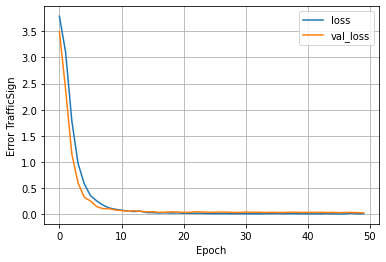

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error TrafficSign')
plt.legend()
plt.grid(True)

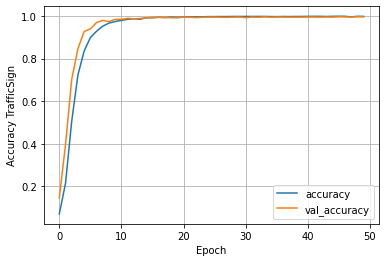

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy TrafficSign')
plt.legend()
plt.grid(True)

In [ ]:
%cd traffic_sign_dataset

/content/traffic_sign_dataset


### Evaluate Test Dataset

In [ ]:
labels_ordered_in_dir = [0,1,10,11,12,13,14,15,16,17,18,19,2,20,21,22,23,24,25,
                         26,27,28,29,3,30,31,32,33,34,35,36,37,38,39,4,40,41,42,
                         5,6,7,8,9]

In [ ]:
!rm Test/GT-final_test.csv

rm: cannot remove 'Test/GT-final_test.csv': No such file or directory


In [ ]:
test_paths = sorted(os.listdir('Test'))

In [ ]:
#defining a function that will scale images
from PIL import Image

def scaling(num_samples):
    images = []
    for x in test_paths[:num_samples]:
        img = Image.open('Test/' + x)
        img = np.array(img)
        img = tf.image.resize(img, (50, 50))
        images.append(img)

    #Converting images into numpy array
    images = np.array(images)

    return images

In [ ]:
test = pd.read_csv('Test.csv')

In [ ]:
labels = np.fromiter((labels_ordered_in_dir.index(x) for x in test['ClassId'].values), 'int64')

In [ ]:
num_samples = 10000
test_imgs = scaling(num_samples)

In [ ]:
test_labels = labels[:num_samples]

In [ ]:
save_model.evaluate(test_imgs, test_labels)

313/313 [==============================] - 212s 678ms/step - loss: 0.3730 - accuracy: 0.9393


[0.3730413615703583, 0.939300000667572]

### Predict

In [ ]:
# Storing all lables
all_lables = ['Speed limit (20km/h)','Speed limit (30km/h)','Speed limit (50km/h)','Speed limit (60km/h)',
              'Speed limit (70km/h)','Speed limit (80km/h)','End of speed limit (80km/h)','Speed limit (100km/h)',
              'Speed limit (120km/h)','No passing','No passing for vechiles over 3.5 metric tons',
              'Right-of-way at the next intersection','Priority road','Yield','Stop','No vechiles',
              'Vechiles over 3.5 metric tons prohibited','No entry','General caution','Dangerous curve to the left',
              'Dangerous curve to the right','Double curve','Bumpy road','Slippery road','Road narrows on the right',
              'Road work','Traffic signals','Pedestrians','Children crossing','Bicycles crossing','Beware of ice/snow',
              'Wild animals crossing','End of all speed and passing limits','Turn right ahead','Turn left ahead',
              'Ahead only','Go straight or right','Go straight or left','Keep right','Keep left','Roundabout mandatory',
              'End of no passing','End of no passing by vechiles over 3.5 metric']

In [ ]:
def predict_sample(path):
  img = Image.open(path)
  img = np.array(img)
  img = tf.image.resize(img, (50, 50))
  img = tf.expand_dims(img, axis=0)

  y = save_model.predict(img)
  l = np.argmax(y, axis = 1)
  l = labels_ordered_in_dir[int(l)]
  return l, all_lables[l]


1/1 [==============================] - 0s 45ms/step


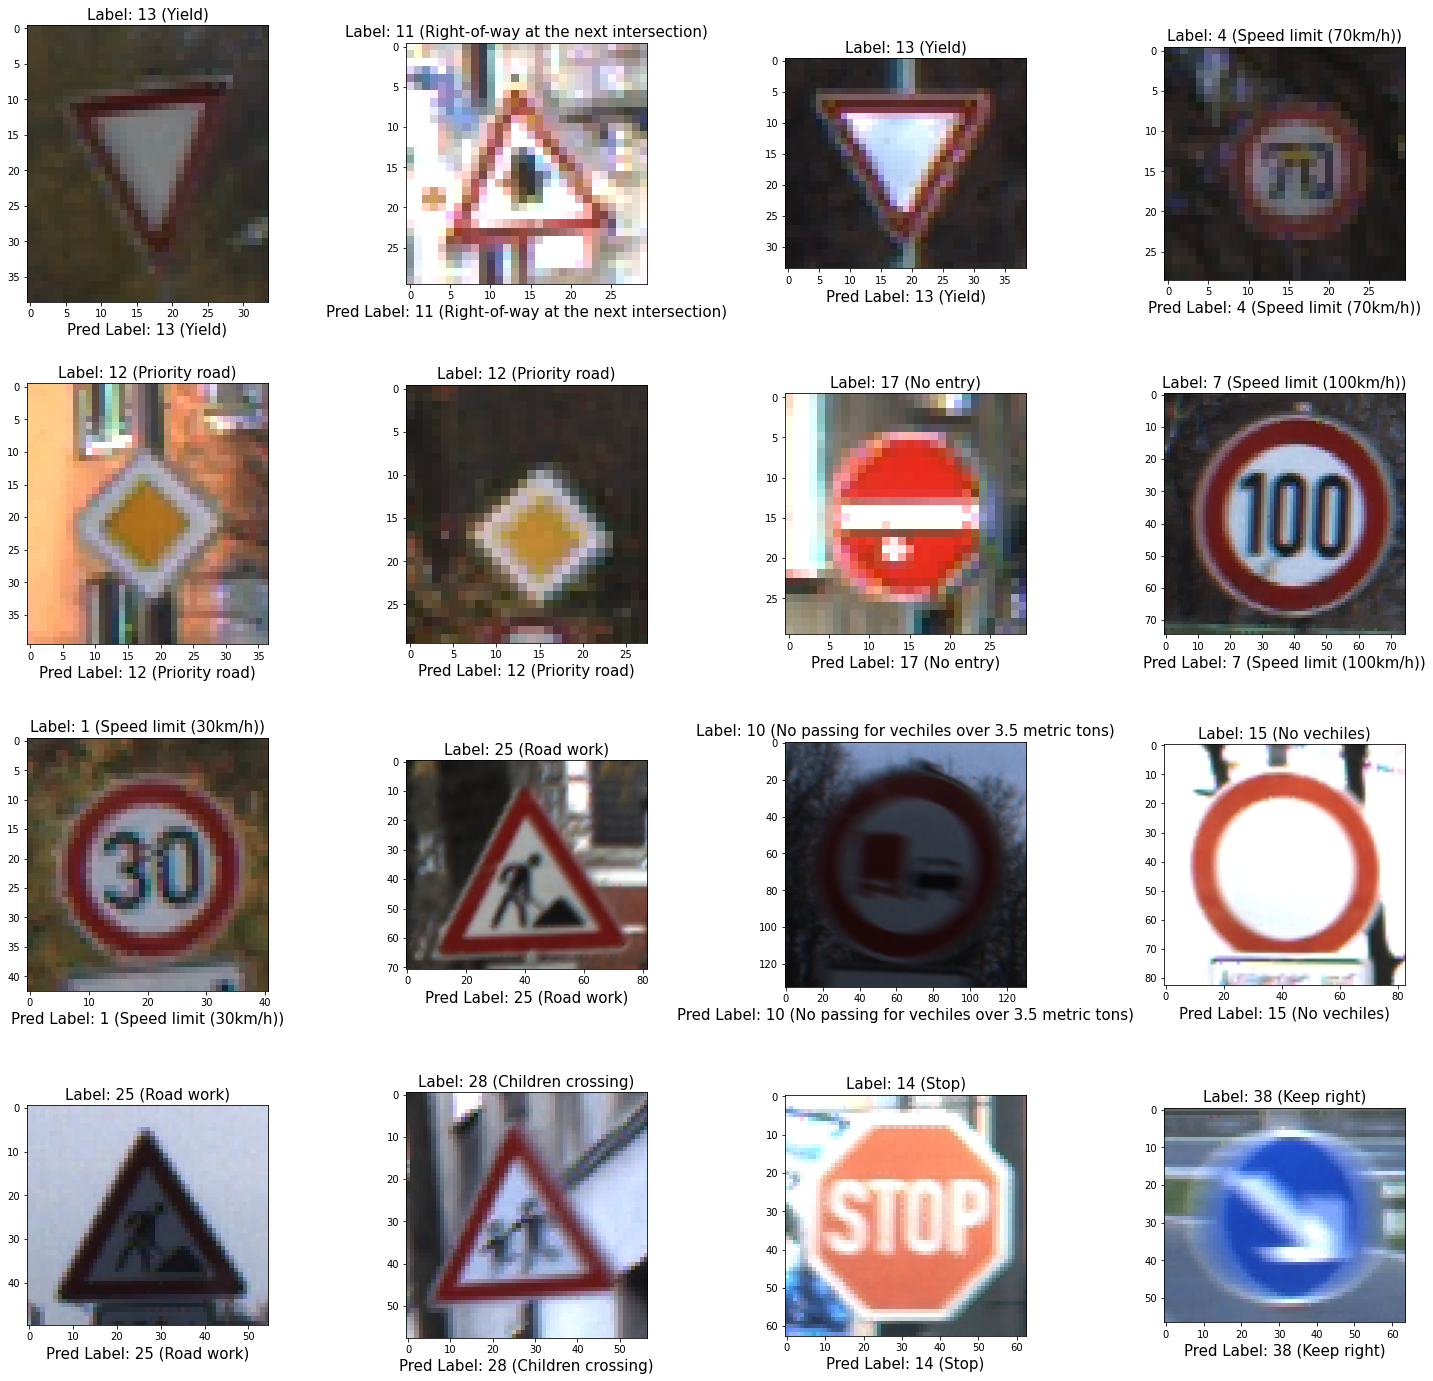

In [ ]:
# Plotting 12 images to predict
plt.figure(figsize=(20,20))
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    r = random.randint(0, len(test_paths) - 1)

    path = 'Test/'+ test_paths[r]
    rand_img = imread(path)
    plt.imshow(rand_img)

    pred_label,pred_text_label = predict_sample(path)

    l = int(test['ClassId'].values[r])
    plt.title(f'Label: {l} ({all_lables[l]})', fontsize = 15)
    plt.xlabel(f'Pred Label: {pred_label} ({pred_text_label})', fontsize = 15)
    


1/1 [==============================] - 0s 47ms/step


Text(0.5, 0, 'Pred Label: 12 (Priority road)')

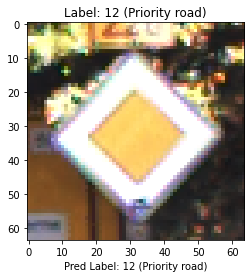

In [ ]:
r = random.randint(0, len(test_paths) - 1)

path = 'Test/'+ test_paths[r]
rand_img = imread(path)
plt.imshow(rand_img)

pred_label,pred_text_label = predict_sample(path)
l = int(test['ClassId'].values[r])
plt.title(f'Label: {l} ({all_lables[l]})')
plt.xlabel(f'Pred Label: {pred_label} ({pred_text_label})', fontsize = 10)
    